In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "serif"
tab10= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
!pip install pywaffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.1/25.1 MB 26.5 MB/s eta 0:00:00


In [2]:
path= '/kaggle/input/kaggle-survey-2022/kaggle_survey_2022_responses.csv'
df_ori= pd.read_csv(path, skiprows= 0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,208,225,255,257,260,270,271,277) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Cleaning and Engineering

In [3]:
# map questions to series
map_questions= df_ori.iloc[0, :]
map_questions.sample(3)

Q38_5     Do you use any of the following automated mach...
Q44_10    Who/what are your favorite media sources that ...
Q35_8     Do you use any of the following data products ...
Name: 0, dtype: object

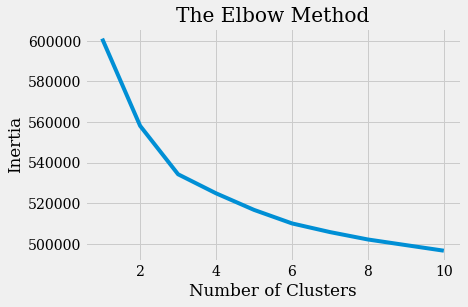

In [4]:
# check how many groups is good

from sklearn.cluster import KMeans

if 'inertias' in locals():
    pass

else:
    inertias= []
    for i in range(1,11):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(pd.get_dummies(
            (df_ori
                .drop(index= 0)
                .drop(columns= 'Duration (in seconds)')
                .replace('No', 0) 
                .replace('Yes', 1)
                .fillna(0)
            ),
            drop_first= True))
        inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [5]:
age_cats= pd.CategoricalDtype(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
                          '45-49', '50-54', '55-59', '60-69', '70+'], ordered= True)
exp_cats= pd.CategoricalDtype(['Blank', 'Not using', 'Under 1 year', '1-2 years', 
                        '2-3 years', '3-4 years','4-5 years', '5-10 years', '10-20 years', 
                        '20 or more years'], ordered= True)
group_cats= pd.CategoricalDtype(['Beginner', 'Intermediate', 'Expert'], ordered= True)
kmeans_model= KMeans(n_clusters= 3, init='k-means++', random_state= 0)

def clean_df(df):
    return(df
        .drop(index= 0) # drop questions rows
        .drop(columns= 'Duration (in seconds)') # drop duration col
        .fillna(0) # fill na with 0
        .replace('No', 0) 
        .replace('Yes', 1)
        .assign(
            Q2= lambda df_: df_['Q2'].astype(age_cats), # age cat
            Q16= lambda df_: (df_['Q16']
                              .replace({0: 'Blank', 'I do not use machine learning methods': 'Not using'})
                              .astype(exp_cats)),
            Group= lambda df_: kmeans_model.fit_predict(pd.get_dummies(df_, drop_first= True)) # group cat, obtained by kmeans
        )
        .assign(
            Group= lambda df_: (df_['Group'].map({0: 'Intermediate', 1: 'Expert', 2: 'Beginner'})).astype(group_cats)
        )
    )

In [6]:
df= clean_df(df_ori)

# EDA

In [7]:
def plot_var_per_group(var, var_name, annotate= False, palette= 'summer'):
    plt.figure(figsize= (15, 5))   
    try:
        ax= sns.barplot(
            data= (df
                    .groupby('Group')[var]
                    .value_counts(normalize= True)
                    .mul(100)
                    .to_frame()
                    .reset_index()
                    .rename({'level_1': var_name, var: 'Percentage'}, axis= 'columns')
                    ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )  
    except:
         ax= sns.barplot(
            data= (df
                .groupby('Group')[var]
                .value_counts(normalize= True)
                .mul(100)
                .to_frame()
                .rename(columns= {var: 'Percentage'})
                .reset_index()
                .rename({var: var_name}, axis= 'columns')
            ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )       
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals= 0))
    plt.legend(ncol= 6, loc= 'upper center', bbox_to_anchor=(0.5, 1.2), frameon= False)
    title= map_questions[var]
    plt.title(title, fontsize= 30, fontweight= 'bold', pad= 80)
    plt.ylabel('Percentage')
    plt.xlabel('')
    if annotate == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()/100, '.2%',), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           size= 12,
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    plt.show()
    
    
def plot_var_per_group2(df1, df2, y, title, upper_xlim):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1= sns.barplot(
        data= df1,
        y= y,
        x= 'value',
        hue= 'Group',
        palette= 'Set1',
        ax= ax1
    )
    ax2= sns.barplot(
        data= df2,
        y= y,
        x= 'value',
        hue= 'Group', 
        palette= 'Set1',
        ax= ax2
    )
    for ax in (ax1, ax2):
        ax.legend([],[], frameon=False) 
        ax.set_ylabel('')
        ax.set_xlabel('Count')
        ax.set_xlim(0, upper_xlim)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor= (0.5, 1.05), ncol= 3, frameon= False)
    plt.suptitle(title, fontsize= 30, fontweight= 'bold', y= 1.3)
    plt.show()
    
def plot_bidirectional_barplot(suptitle, index, column1, title1, column2, title2, plot_size, title_pad= 25):
    color1= '#1f77b4'
    color2= '#d62728'

    fig, (ax1, ax2) = plt.subplots(figsize= plot_size, ncols=2, sharey= True)

    ax1.barh(index, column1, align='center', color= color1, zorder=10)
    ax1.set_title(title1, fontsize=18, pad= title_pad, color= color1)

    ax2.barh(index, column2, align='center', color= color2, zorder=10)
    ax2.set_title(title2, fontsize=18, pad= title_pad, color= color2)

    plt.gca().invert_yaxis() # sort y-axis a-z
    ax1.invert_xaxis() # invery y axis from ax2

    # sey both ylim to 0-100
    ax2.set_xticks(list(range(0, 120, 20)))
    ax2.set_xticks(list(reversed((range(0, 120, 20)))))

    for ax in (ax1, ax2):
#         ax.xaxis.set_visible(False)
        ax.xaxis.tick_top()
        ax.tick_params(axis='x', which='major', pad= -(ax.get_ylim()[0]/2))
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        
    plt.suptitle(suptitle, fontsize= 30, fontweight= 'bold', y= 1)

    fig.tight_layout()
    plt.show()
    
def plot_waffle(title, num_col, values, labels, figsize= (15, 5), colors = tab10, 
    x_title= 0.43, y_title= 1.4, legend_bbox= (0.43, 1.3), n_col_legend= 6):
    
    from pywaffle import Waffle
    
    num_labels= len(labels)
    diff= num_labels - len(colors)
    for i in list(range(0, diff)):
        colors.append(colors[i])

    ax = plt.figure(
        FigureClass= Waffle, 
        columns = num_col, 
        values= values,
        labels= labels,
        rounding_rule='floor',
        figsize= figsize,
        colors= colors,
        title={
            'label': title,
            'loc': 'center',
            'x': x_title,
            'y': y_title,
            'fontdict': {
                'fontsize': 30,
                'fontweight': 'bold'
            }
        },
        legend={
            'loc': 'upper center',
            'bbox_to_anchor': legend_bbox,
            'ncol': n_col_legend,
            'framealpha': 0,
            'fontsize': 12
        }
    )
    
def plot_normalized_hbar(data, title, figsize= (15, 12)):
                  
    category_names= data.columns.tolist()
    labels= data.index.tolist()
    data= np.array(data)

    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize= figsize, dpi= 150)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), loc='upper center', bbox_to_anchor= (0.5, 1.05), frameon= False)
    ax.set_title(title, fontsize= 30, fontweight= 'bold', pad= 70)

    return fig, ax

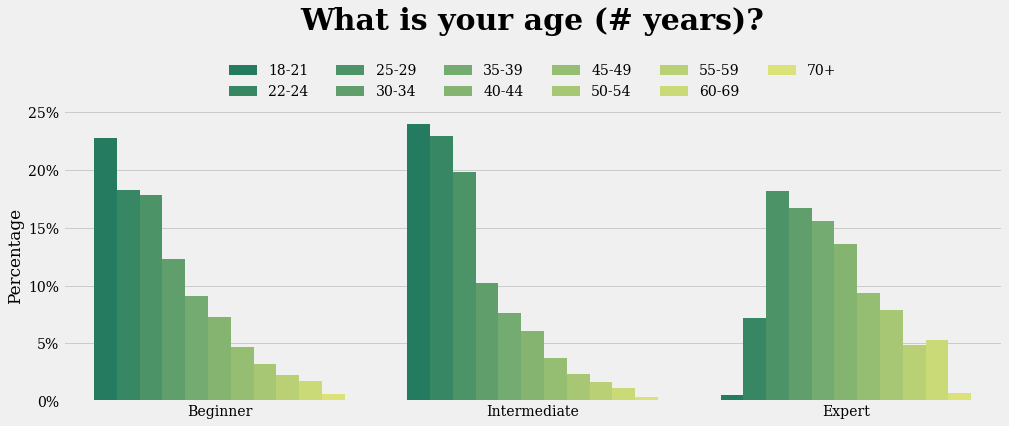

In [8]:
plot_var_per_group('Q2', 'Age')

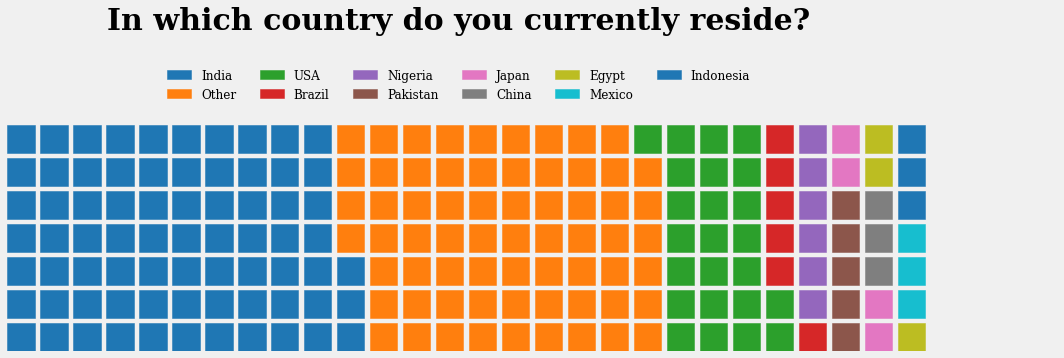

In [9]:
countries= df['Q4'].value_counts(normalize= True)
countries['Other'] = countries['Other'] + countries[11:].sum()
countries_top10= countries[:11].sort_values(ascending= False)
countries_top10= countries_top10.rename(index= {'United States of America': 'USA'})

plot_waffle(
    title= map_questions['Q4'], 
    num_col= 32, 
    values= list(countries_top10.values * 200), 
    labels= list(countries_top10.index)
)

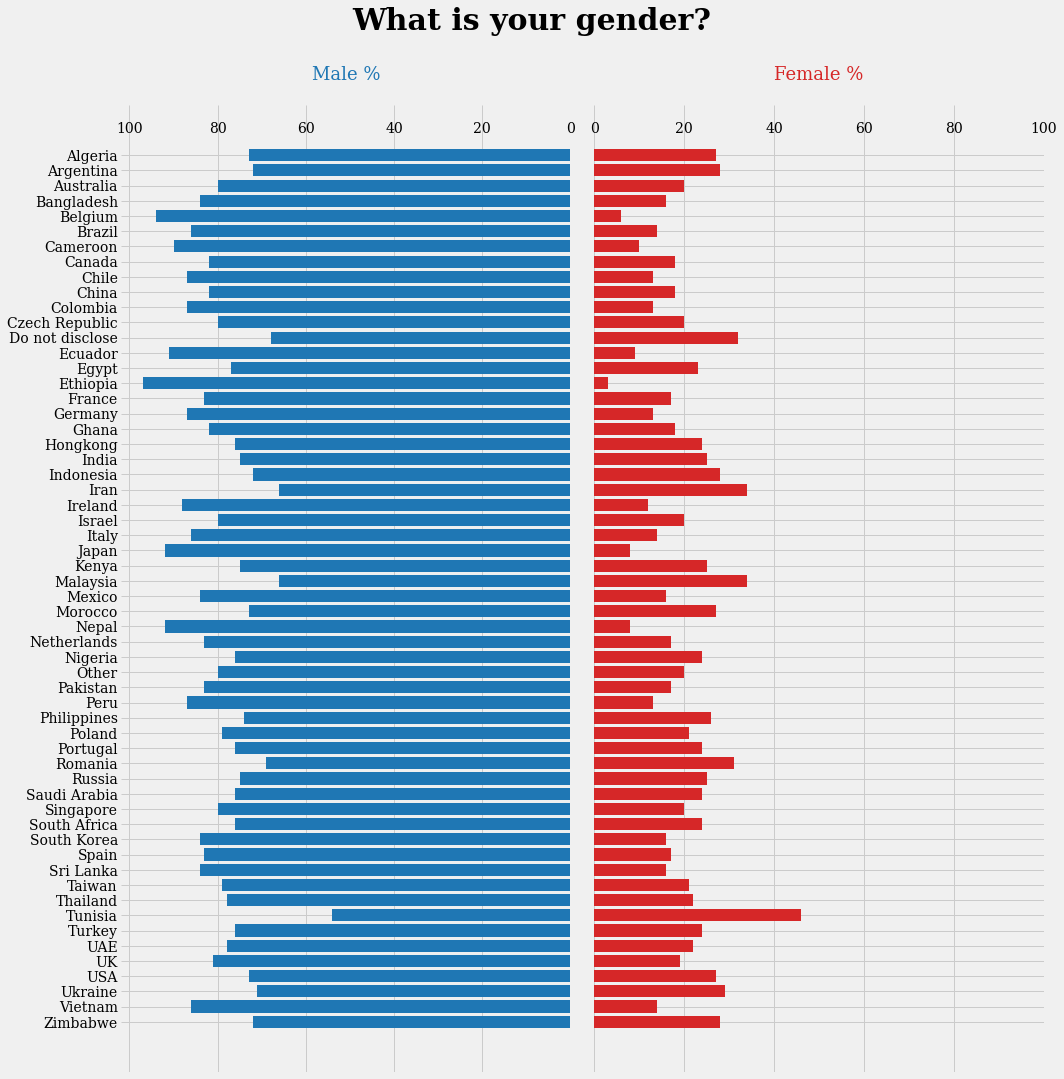

In [10]:
map_country= {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Iran, Islamic Republic of...': 'Iran',
    'Viet Nam': 'Vietnam',
    'United Arab Emirates': 'UAE',
    'Hong Kong (S.A.R.)': 'Hongkong',
    'I do not wish to disclose my location': 'Do not disclose'
}

df_q4= (df
    ['Q4']
    .replace(map_country)
    .to_frame()
    .assign(
        Gender= df['Q3'].where(df['Q3'].isin(['Man', 'Woman']), 'Other')
    )
    .query('`Gender` != "Other"')
    .groupby(['Q4', 'Gender'])
    .agg(Count= ('Gender', 'size'))
    .reset_index()
    .rename(columns= {'Q4': 'Nationality'})
    .assign(Perc= lambda df_: round(((df_['Count'] / df_.groupby('Nationality')['Count'].transform('sum'))* 100), 0))
    .pivot(index= 'Nationality', columns= 'Gender', values= 'Perc')
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?',
    index = df_q4.index, 
    column1 = df_q4['Man'], title1 = 'Male %', 
    column2 = df_q4['Woman'], title2 = 'Female %', 
    plot_size= (15,15)
)

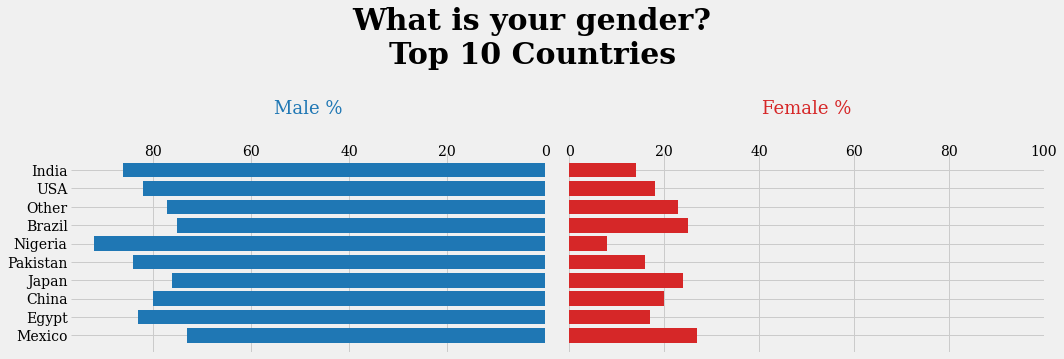

In [11]:
top10_countries= df['Q4'].value_counts()[:10].index.tolist()
# replace united states with usa
top10_countries= ['USA' if x == 'United States of America' else x for x in top10_countries] 

df_q4_selected= (df_q4
    .loc[df_q4.index.isin(top10_countries)]
    .set_index(pd.CategoricalIndex(top10_countries, ordered= True))
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?\nTop 10 Countries',
    index = df_q4_selected.index, 
    column1 = df_q4_selected['Man'], title1 = 'Male %', 
    column2 = df_q4_selected['Woman'], title2 = 'Female %', 
    plot_size= (15, 5),
    title_pad= 40
)

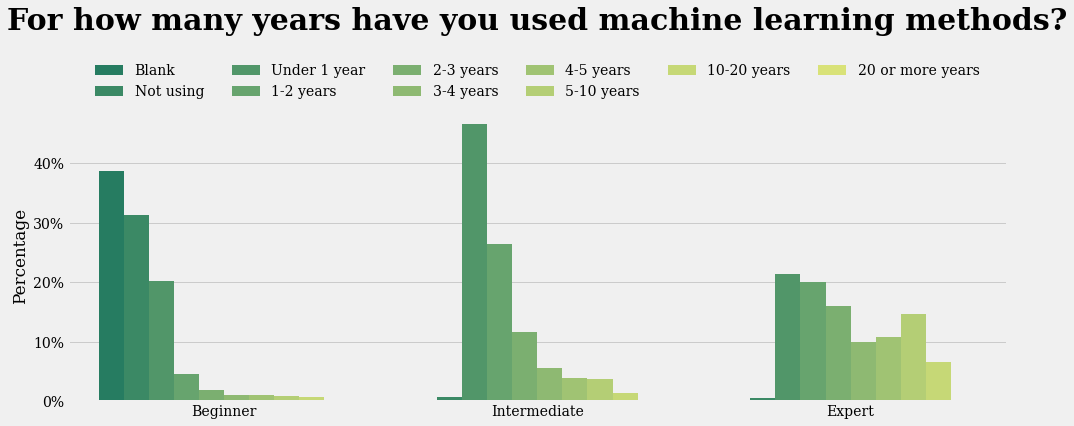

In [12]:
plot_var_per_group('Q16', 'ML Experience')

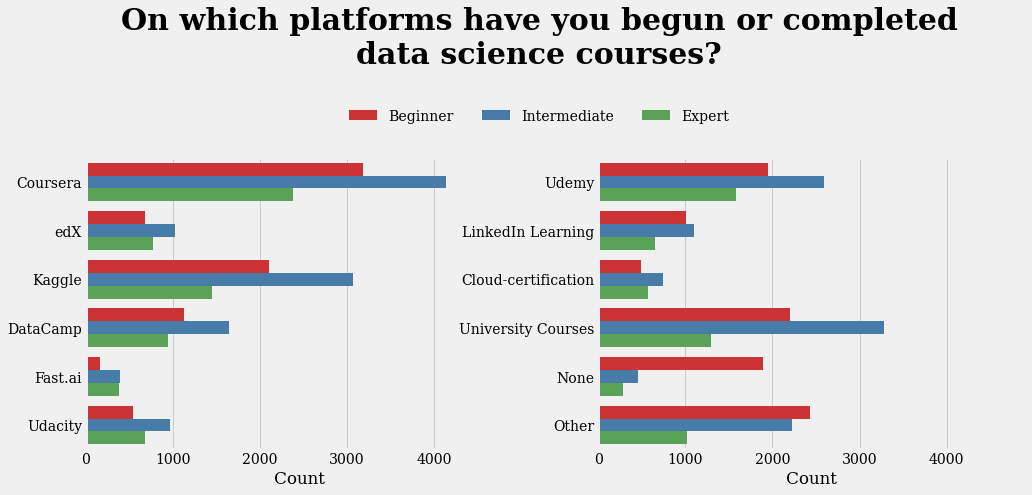

In [13]:
import re
mask_question= df.columns[df.columns.str.contains('Q6')]
df_q6= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
)
df_q6.columns= (df_q6.columns
    .str.replace('On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - ', '', regex= False)
    .str.replace(' (direct from AWS, Azure, GCP, or similar)', '', regex= False)
    .str.replace(' (resulting in a university degree)', '', regex= False)
    .str.replace(' Learn Courses', '', regex= False)
    .str.replace(' programs', '', regex= False)
)
df_q6= (df_q6
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q6.iloc[0:int(len(df_q6)/2),:],
    df_q6.iloc[int(len(df_q6)/2):,:], 
    'variable', 
    "On which platforms have you begun or completed\ndata science courses?", 
    4900
)

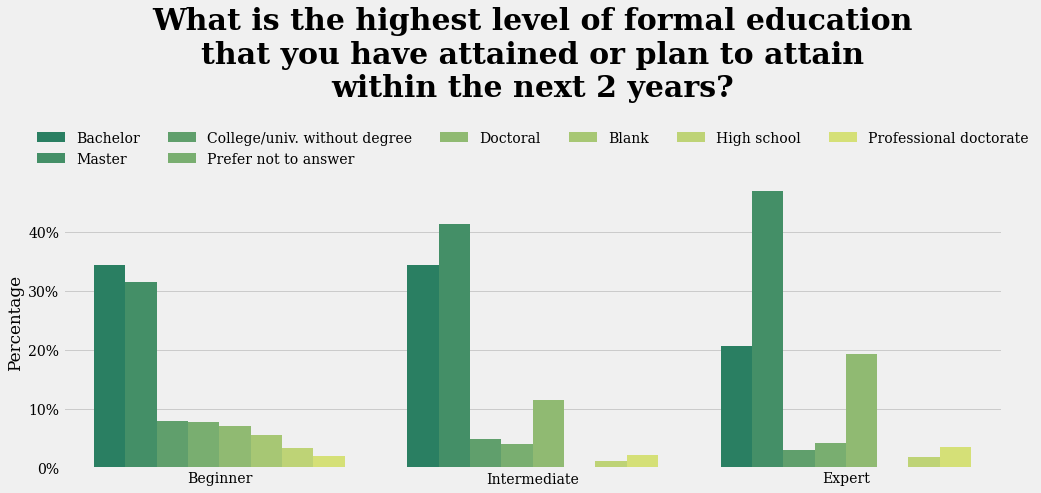

In [14]:
map_educations= {0: 'Blank',
 'Master’s degree': 'Master',
 'Bachelor’s degree': 'Bachelor',
 'Some college/university study without earning a bachelor’s degree': 'College/univ. without degree',
 'Doctoral degree': 'Doctoral',
 'I prefer not to answer': 'Prefer not to answer',
 'Professional doctorate': 'Professional doctorate',
 'No formal education past high school': 'High school'}

df= (df
    .assign(Q8= df['Q8'].map(map_educations))
)

map_questions['Q8']= 'What is the highest level of formal education\nthat you have attained or plan to attain\nwithin the next 2 years?'
plot_var_per_group('Q8', 'Education')

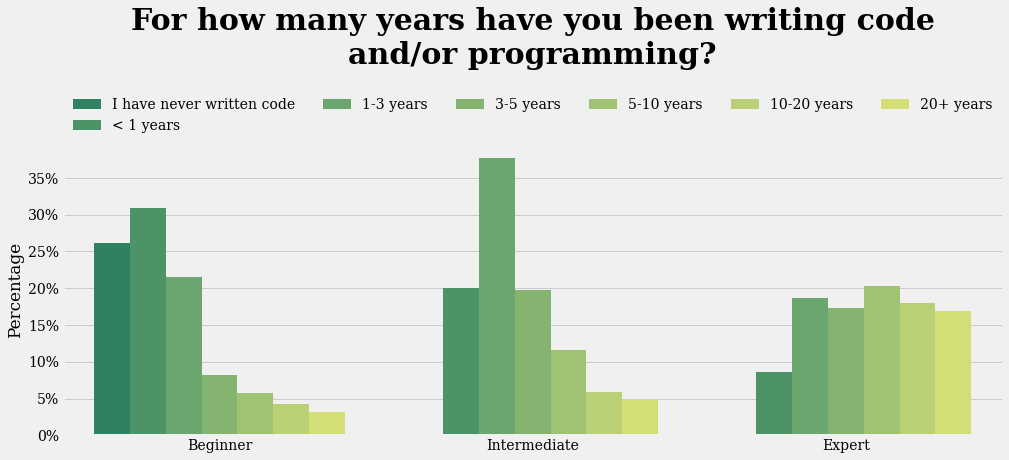

In [15]:
df= (df
    .assign(Q11= df['Q11'].replace(0, 'I have never written code'))
    .assign(Q11= lambda df_: df_['Q11'].astype(
        pd.CategoricalDtype(categories= ['I have never written code', '< 1 years', '1-3 years', '3-5 years', '5-10 years', 
                                        '10-20 years', '20+ years'], ordered= True)
    ))
)
map_questions['Q11'] = 'For how many years have you been writing code\nand/or programming?'
plot_var_per_group('Q11', 'Code')

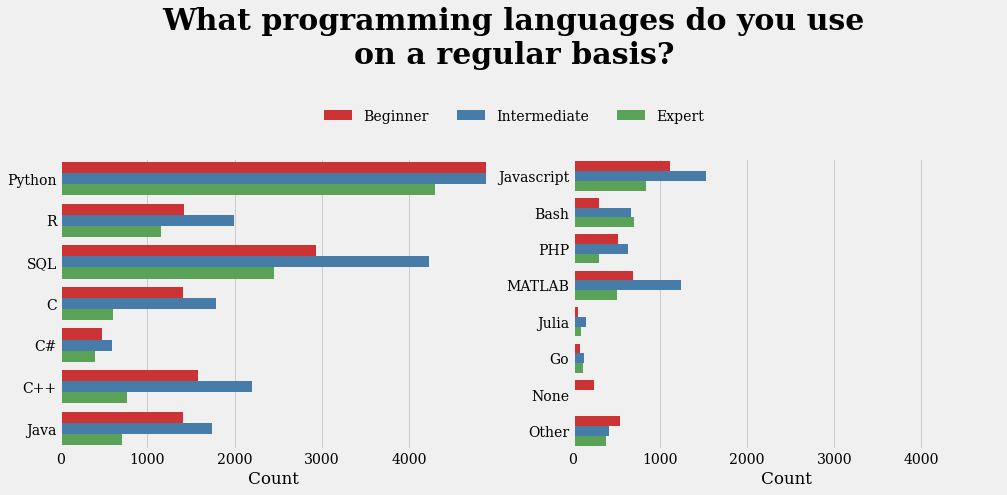

In [16]:
mask_question= df.columns[df.columns.str.contains('Q12')]
df_q12= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
    .rename(columns= lambda c: c.replace('What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - ', ''))
)
df_q12= (df_q12
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q12.iloc[0:int(len(df_q12)/2 - 1),:],
    df_q12.iloc[int(len(df_q12)/2 - 1):,:], 
    'variable', 
    "What programming languages do you use\non a regular basis?", 
    4900
)

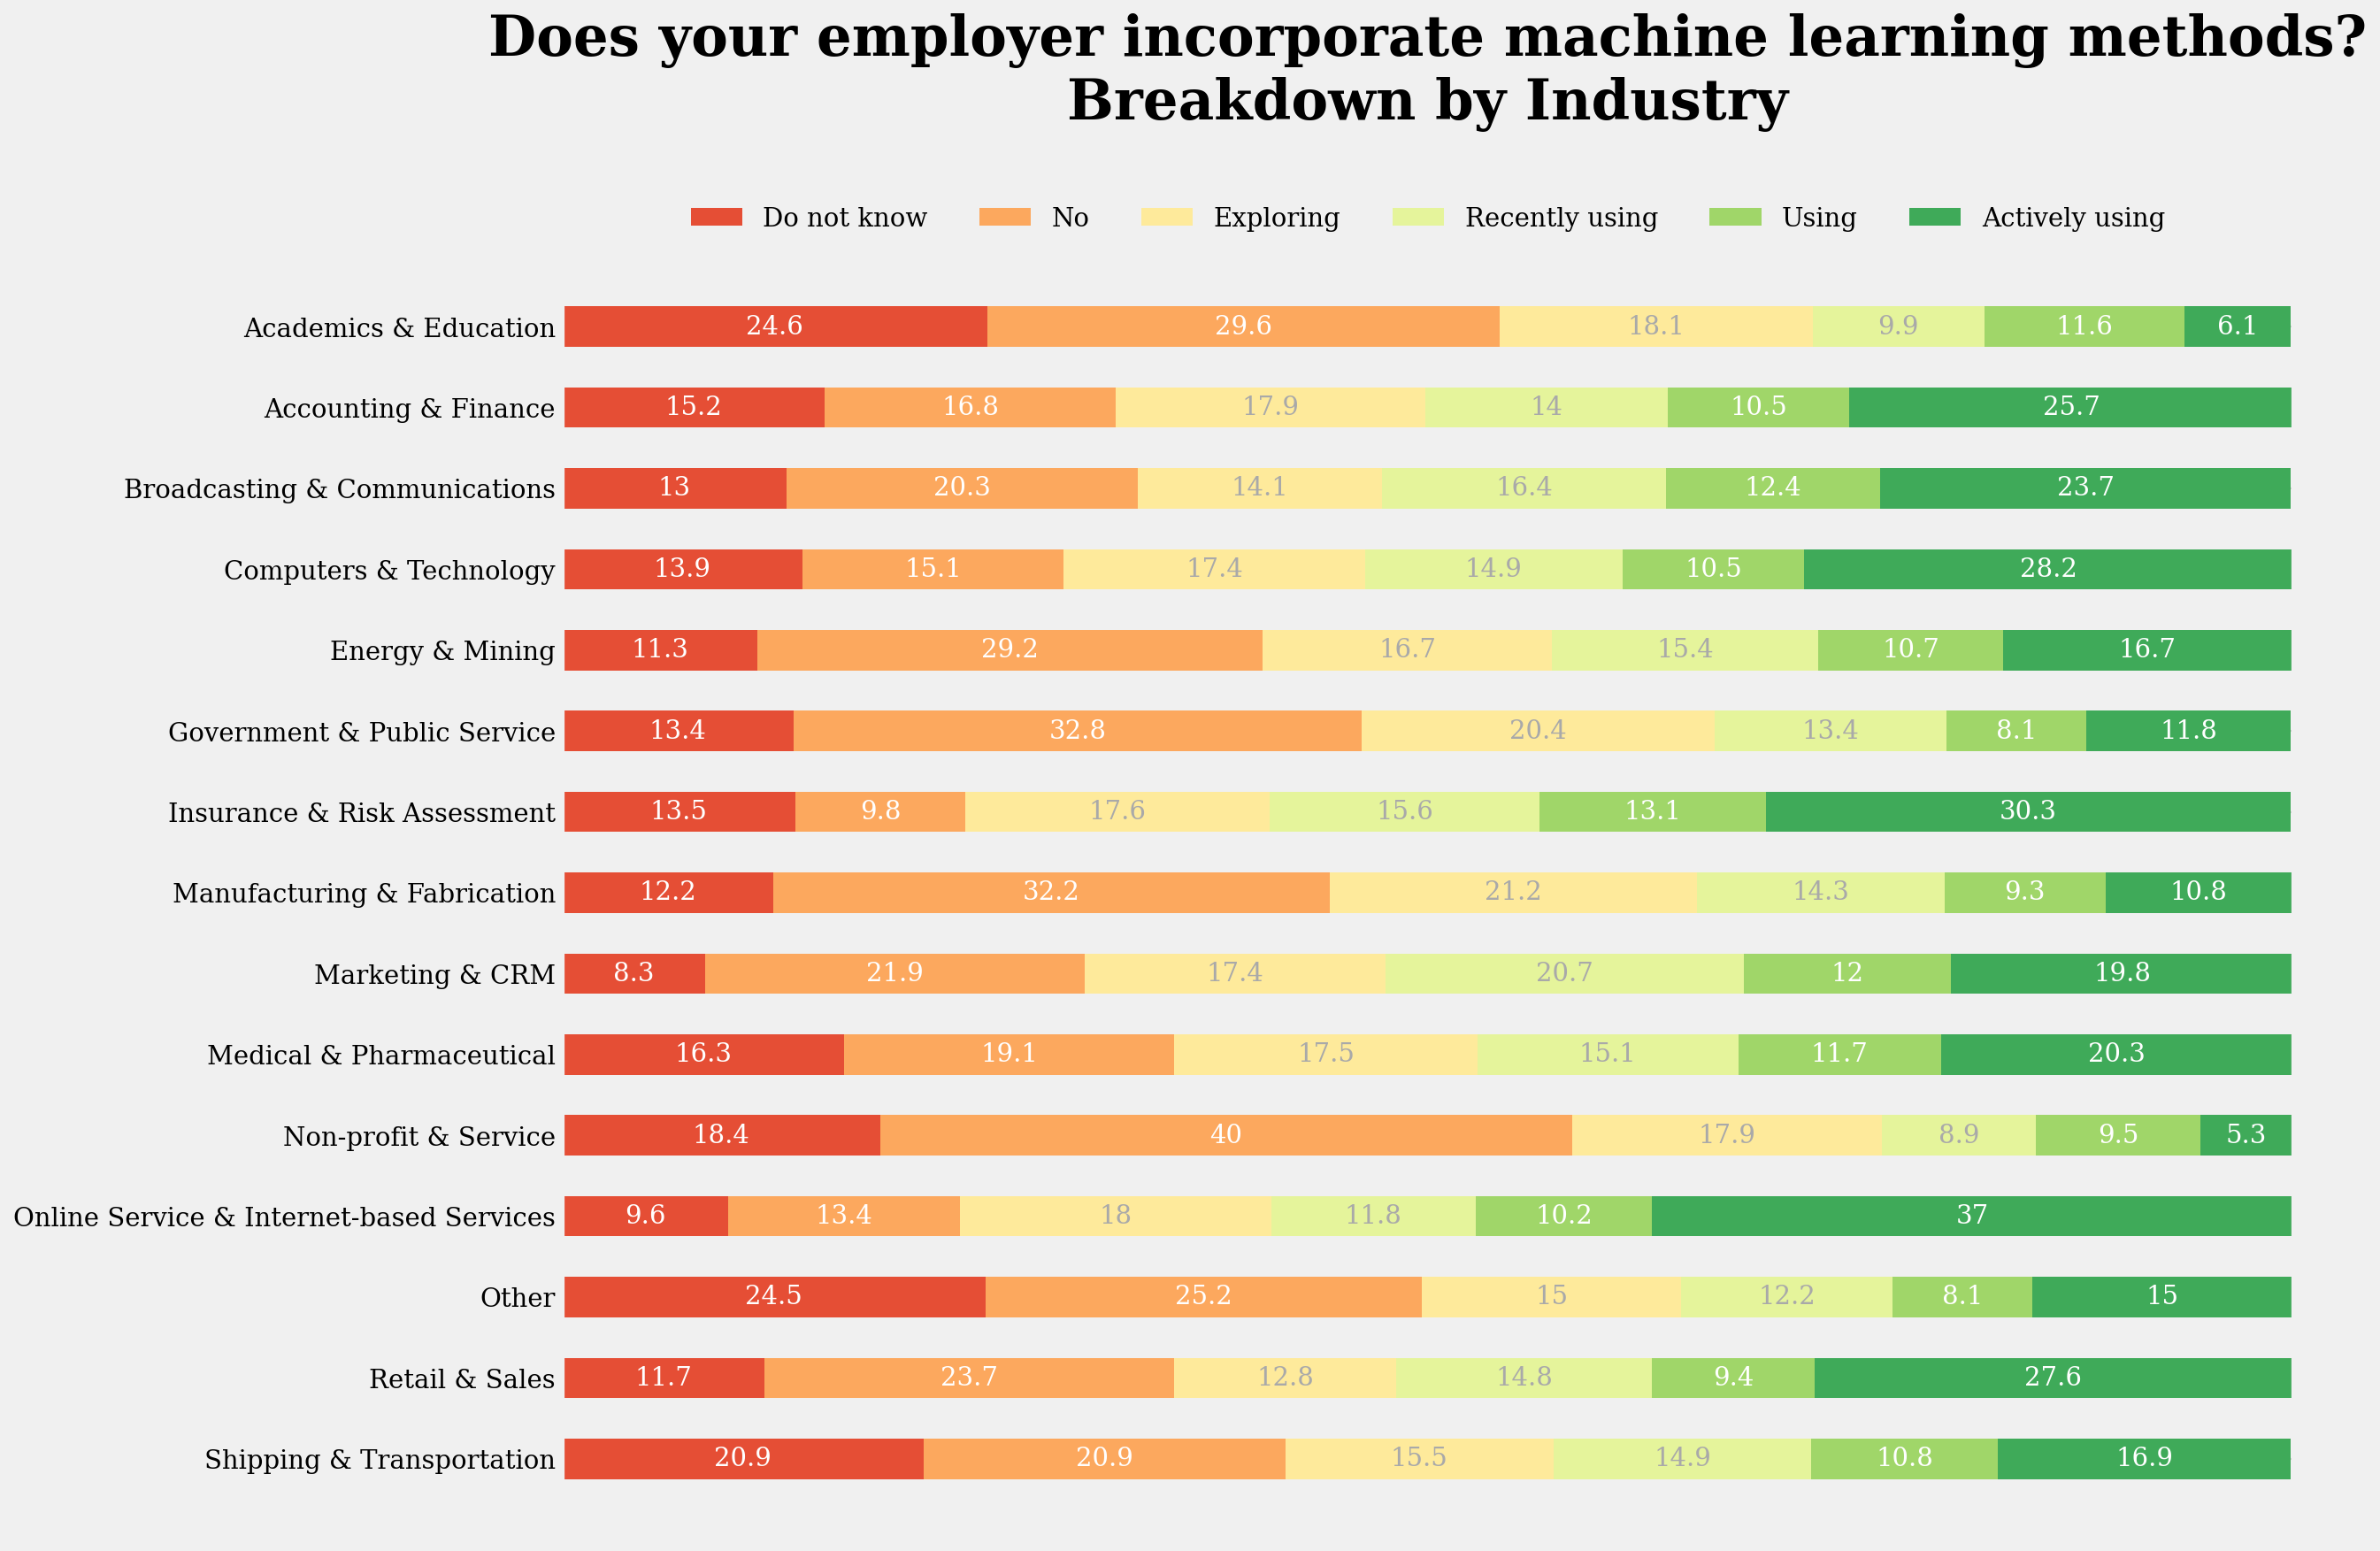

In [17]:
data_q24_q27= (df
    [['Q24', 'Q27']]
    .query('Q24 != 0 & Q27 != 0')
    .assign(
        Q24= lambda df_: df_['Q24'].str.replace('/', ' & ', regex= False),
        Q27= lambda df_: df_['Q27'].str.replace(' \(.+\)', '', regex= True).replace({
            'We recently started using ML methods': 'Recently using', 
            'We have well established ML methods': 'Actively using',
            'We are exploring ML methods': 'Exploring',
            'I do not know': ' Do not know',
            'We use ML methods for generating insights': 'Using'
        }).str.strip()
    )
    .assign(
        Q27= lambda df_: df_['Q27'].astype(pd.CategoricalDtype(
            categories= ['Do not know', 'No', 'Exploring', 'Recently using', 'Using', 'Actively using'], ordered= True
        ))
    )
    .groupby(['Q24', 'Q27'])
    .agg(Count= ('Q24', 'size'))
    .reset_index()
    .assign(
        Perc= lambda df_ : round((df_['Count'] / df_.groupby('Q24')['Count'].transform('sum') * 100), 1)
    ) 
    .pivot_table(index= 'Q24', columns= ['Q27'], values= 'Perc')
)

title= 'Does your employer incorporate machine learning methods?\nBreakdown by Industry'
plot_normalized_hbar(data= data_q24_q27, title= title)
plt.show()